#Header

## Herman Franclin Tesso Tassang



# Setup

In [ ]:
import numpy as np
import pandas as pd
import random
import math
np.random.seed(42)

import matplotlib.pyplot as plt
FONTSIZE = 16
params = {
         'figure.figsize' : (6,6),
         'axes.labelsize' : FONTSIZE,
         'axes.titlesize' : FONTSIZE+2,
         'legend.fontsize': FONTSIZE,
         'xtick.labelsize': FONTSIZE,
         'ytick.labelsize': FONTSIZE,
         'xtick.color'    : 'black',
         'ytick.color'    : 'black',
         'axes.facecolor' : 'white',
         'axes.edgecolor' : 'black',
         'axes.titlepad'  :  20,
         'axes.labelpad'  :  10}
plt.rcParams.update(params)

XNAME = 'x1'; XLABEL = r'$x_1$'
YNAME = 'x2'; YLABEL = r'$x_2$'
RANGE = (-6, 6); STEP = 0.1

def predict(output_node, boundary_value):
  output_node.reshape(-1, 1, 1) # a list (m, 1, 1)
  predictions = np.array(output_node > boundary_value, dtype=int)
  return predictions

def plot_cost_vs_iter(train_costs, test_costs, title="Cost evolution"):

  fig, ax = plt.subplots(figsize=(8, 6))
  iters = np.arange(1,len(train_costs)+1)
  ax.plot(iters, train_costs, color='red', lw=1, label='Training set')
  ax.plot(iters, test_costs, color='blue', lw=1, label='Testing set')
  ax.set_xlabel("Number of iterations"); ax.set_xlim(1, iters[-1])
  ax.set_ylabel("Cost")
  ax.legend(loc="upper right", frameon=False)
  ax.set_title(title)
  plt.show()


def get_decision_surface(weights, biases, boundary=0.5, range=RANGE, step=STEP):

  # Create a grid of points spanning the parameter space:
  x1v, x2v = np.meshgrid(np.arange(range[0], range[1]+step, step),
                         np.arange(range[0], range[1]+step, step))

  # Stack it so that it is shaped like X_train: (m,2)
  X_grid = np.c_[x1v.ravel(), x2v.ravel()].reshape(-1,2)

  # Feedforward on all grid points and get binary predictions:
  output = feedforward(X_grid, weights, biases)[-1] # getting only output node
  Ypred_grid = predict(output, boundary)

  return (x1v, x2v, Ypred_grid.reshape(x1v.shape))


def plot_scatter(sig, bkg, ds=None, xname=XNAME, xlabel=XLABEL, yname=YNAME, ylabel=YLABEL, range=RANGE, step=STEP, title="Scatter plot"):

  fig, ax = plt.subplots()

  # Decision surface
  if ds:
    (xx, yy, Z) = ds # unpack contour data
    cs = plt.contourf(xx, yy, Z, levels=[0,0.5,1], colors=['orange','dodgerblue'], alpha=0.3)

  # Scatter signal and background:
  ax.scatter(sig[xname], sig[yname], marker='o', s=10, c='dodgerblue', alpha=1, label='Positive class')
  ax.scatter(bkg[xname], bkg[yname], marker='o', s=10, c='orange',     alpha=1, label='Negative class')

  # Axes, legend and plot:
  ax.set_xlim(range); ax.set_xlabel(xlabel)
  ax.set_ylim(range); ax.set_ylabel(ylabel)

  ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", frameon=False)
  ax.set_title(title)
  plt.show()

# 1. Get the Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

file_path1='/content/gdrive/MyDrive/Shortcut to courses materials/ML by hand/ml_a3/ml_a3_data_train.csv'
train=pd.read_csv(file_path1)
print('shape of the train dataset:{}'.format(train.shape))

print('')

file_path2='/content/gdrive/MyDrive/Shortcut to courses materials/ML by hand/ml_a3/ml_a3_data_test.csv'
test=pd.read_csv(file_path2)

print('shape of the test dataset:{}'.format(test.shape))
train.head(5)

shape of the train dataset:(320, 3)

shape of the test dataset:(80, 3)


,x1,x2,class
0,-0.136282,3.244889,0
1,-5.305888,5.629232,0
2,-4.147647,-0.226319,1
3,-2.170794,3.946986,0
4,-5.555908,1.155239,0


### Answer:
* There are exactly 320 and 80 data samples in train and test dataframe respectively.

* The name of the column containing the labels is "**class**" and  class values are $1$ (signal) and $0$ (background).

###1.2: Split signal vs background

In [ ]:
sig=train[train['class']==1]
bkg=train[train['class']==0]

### DataFrame to numpy

In [ ]:
inputs = ['x1', 'x2']
X_train = train[inputs].values
y_train = train['class'].values

X_test = test[inputs].values
y_test = test['class'].values

type(X_train)

numpy.ndarray

# Functions

### 2.1 Weighted sum

In [ ]:
def z( W, a , b ):
  """W: weights at the current layer
  a: ouputs of the previous layer
  b: biases vector of the current layer """
  return np.matmul(W,a)+b

### 2.2: Activation Functions and Derivatives

In [ ]:
def tanh(z):
  return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))

def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

def tanh_prime(z):
    return 1-(tanh(z))**2

### 2.3: Cross-entropy cost function

In [ ]:
def cross_entropy_cost(y_preds, y_vals,eps=1e-15):

  return -(1/len(y_vals))*np.sum(y_vals*np.log(y_preds+eps)+(1-y_vals)*np.log(1-y_preds+eps))

### 2.4: Derivative of the Loss

$$
L\left(\hat{y}^{(i)}, y^{(i)}\right)=-\left\lceil y^{(i)} \log \left(\hat{y}^{(i)}\right)+\left(1-y^{(i)}\right) \log \left(1-\hat{y}^{(i)}\right)\right\rceil
$$


$$ .. $$

\begin{align*}
\frac{\mathrm{d}}{\mathrm{d} \hat{y}^{(i)}} L\left(\hat{y}^{(i)}, y^{(i)}\right)&=-\Big[ y^{(i)} (\log){'} \left(\hat{y}^{(i)}\right)+\left(1-y^{(i)}\right) (\log){'} \left(1-\hat{y}^{(i)}\right)\Big]\\
&=-\Big[\frac{y^{(i)}}{\hat{y}^{(i)}}-\frac{1-y^{(i)}}{1-\hat{y}^{(i)}}\Big]
\end{align*}


In [ ]:
def L_prime(y_preds, y_obs):
    return (1-y_obs)/(1-y_preds)-y_obs/y_preds

In [ ]:
def feedforward(input_X, weights, biases):

  W1, W2, W3 = weights ; b1, b2, b3 = biases

  m  = len(input_X)
  a0 = input_X.reshape((m, -1, 1))

  # First layer
  z1=z(W1.T,a0,b1)
  a1=tanh(z1)

  # Second layer
  z2=z(W2.T,a1,b2)
  a2=tanh(z2)

  # Third layer
  z3=z(W3.T,a2,b3)
  a3=sigmoid(z3)

  nodes = [a0, z1, a1, z2, a2, z3, a3]

  return nodes

### 3.2: Predict

Answer:

  *  What is the output_node in the context of our 2-hidden-layered neural network?
    * **The output node in out context is "**a3**"; the ouput of the last layer.**

  *  What type of values does the function predict return?
    * **The function predict return integer values: either** **0** or **1** .

* After successfully executing the feedforward function, how would you call the function predict?
  * The function predict could be call the **classifier** .



In [ ]:
# Hyperparameters
alpha = 0.2
N = 1500 # epochs

# Initialization
m = len(X_train)     # number of data samples
n = X_train.shape[1] # number of input features
q = 3 # number of nodes in first hidden layer
r = 2 # number of nodes in second hidden layer

# WEIGHT MATRICES + BIASES
W1 =  np.random.normal(scale=np.sqrt(2/(n+q)), size=(n, q))  # Xavier initialization of the weights
W2 =  np.random.normal(scale=np.sqrt(2/(q+r)), size=(q, r))
W3 =  np.random.normal(scale=np.sqrt(2/(r+1)), size=(r, 1))
b1 =  np.random.randn(q,1)*0.01                             # initialize biases with small numbers (close to zero)
b2 =  np.random.randn(r,1)*0.01
b3 =  np.random.randn(1)*0.01

# OUTPUT LAYER
y_train = np.reshape(y_train, (-1, 1, 1))
y_test  = np.reshape(y_test , (-1, 1, 1))

# Storing cost values for train and test datasets
costs_train = []
costs_test  = []
debug = True

print("Starting the training\n")

# -------------------
#   Start iterations
# -------------------
for t in range(1, N+1):

  # FORWARD PROPAGATION
  # Feedforward on test data:
  nodes_test = feedforward(X_test, [W1,W2,W3],[b1,b2,b3])  #tanspose X_test?
  ypreds_test = predict(output_node=nodes_test[-1], boundary_value=0.5)

  # Feedforward on train data:
  a0, z1, a1, z2, a2, z3, a3 = feedforward(X_train, [W1,W2,W3],[b1,b2,b3])
  ypreds_train =  predict(output_node=a3, boundary_value=0.5)

  # Cost computation and storage
  J_train = cross_entropy_cost(ypreds_train, y_train)
  J_test  = cross_entropy_cost(ypreds_test,  y_test )
  costs_train.append(J_train)
  costs_test.append(J_test)

  if (t<=100 and t % 10 == 0) or (t>100 and t % 100 == 0):
      print(f"Iteration {t}\t Train cost = {J_train:.4f}  Test cost = {J_test:.4f}   Diff = {J_test-J_train:.5f}")

  # BACKWARD PROPAGATION
  # Errors delta:
  delta_3 = sigmoid_prime(z3)*L_prime(a3, y_train)
  delta_2 = tanh_prime(z2)*(np.matmul(W3,delta_3))
  delta_1 = tanh_prime(z1)*(np.matmul(W2,delta_2))

  # Partial derivatives:
  dCostdW3 = (1/m)*np.sum(np.matmul(a2,np.transpose(delta_3,axes=(0,2,1))),axis=0)
  dCostdW2 = (1/m)*np.sum(np.matmul(a1,np.transpose(delta_2,axes=(0,2,1))),axis=0)
  dCostdW1 = (1/m)*np.sum(np.matmul(a0,np.transpose(delta_1,axes=(0,2,1))),axis=0)
  dCostdb3 = (1/m)*np.sum(delta_3, axis=0)
  dCostdb2 = (1/m)*np.sum(delta_2, axis=0)
  dCostdb1 = (1/m)*np.sum(delta_1, axis=0)

  if debug and t<3:
    print(f"a0: {a0.shape} a1: {a1.shape} a2: {a2.shape} a3: {a3.shape} ")
    print(f"W3: {W3.shape} z1: {z1.shape} z2: {z2.shape} z3: {z3.shape} ")
    print(f"dCostdW3: {dCostdW3.shape} dCostdW2: {dCostdW2.shape} dCostdW1: {dCostdW1.shape}")

  # Update of weights and biases
  W3 = W3-alpha*dCostdW3
  W2 = W2-alpha*dCostdW2
  W1 = W1-alpha*dCostdW1
  b3 = b3-alpha*dCostdb3
  b2 = b2-alpha*dCostdb2
  b1 = b1-alpha*dCostdb1

print(f'\nEnd of gradient descent after {t} iterations')

Starting the training

a0: (320, 2, 1) a1: (320, 3, 1) a2: (320, 2, 1) a3: (320, 1, 1) 
W3: (2, 1) z1: (320, 3, 1) z2: (320, 2, 1) z3: (320, 1, 1) 
dCostdW3: (2, 1) dCostdW2: (3, 2) dCostdW1: (2, 3)
a0: (320, 2, 1) a1: (320, 3, 1) a2: (320, 2, 1) a3: (320, 1, 1) 
W3: (2, 1) z1: (320, 3, 1) z2: (320, 2, 1) z3: (320, 1, 1) 
dCostdW3: (2, 1) dCostdW2: (3, 2) dCostdW1: (2, 3)
Iteration 10	 Train cost = 16.5139  Test cost = 13.8155   Diff = -2.69834
Iteration 20	 Train cost = 14.3552  Test cost = 12.0886   Diff = -2.26661
Iteration 30	 Train cost = 16.0821  Test cost = 18.5646   Diff = 2.48247
Iteration 40	 Train cost = 16.0821  Test cost = 18.5646   Diff = 2.48247
Iteration 50	 Train cost = 16.0821  Test cost = 18.5646   Diff = 2.48247
Iteration 60	 Train cost = 16.0821  Test cost = 18.5646   Diff = 2.48247
Iteration 70	 Train cost = 16.0821  Test cost = 18.5646   Diff = 2.48247
Iteration 80	 Train cost = 16.0821  Test cost = 18.5646   Diff = 2.48247
Iteration 90	 Train cost = 14.3552  Tes

#5. Plots

### 5.1: Cost evolution

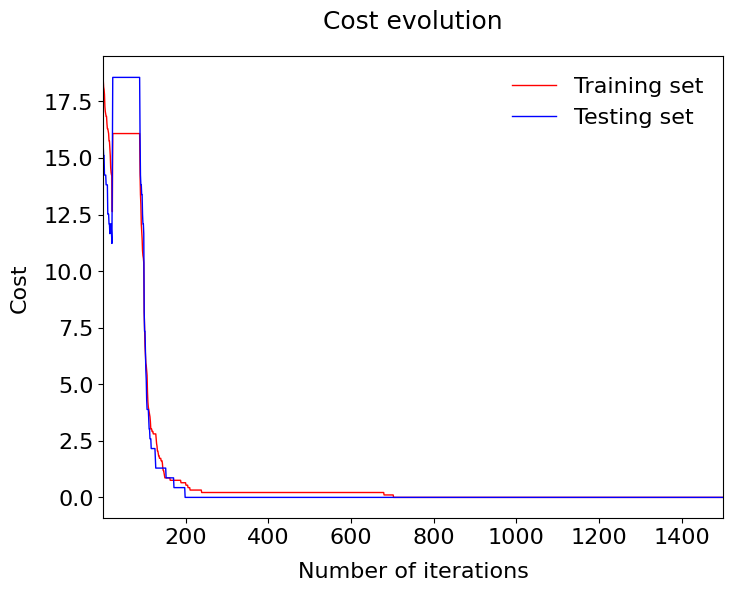

In [ ]:
plot_cost_vs_iter(costs_train, costs_test, title="Cost evolution")

### 5.2: Scatter Plot

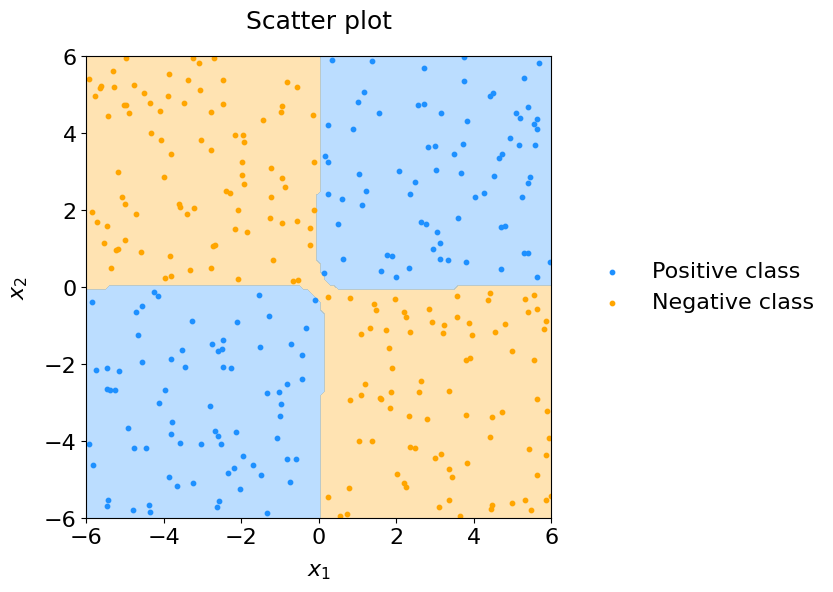

In [ ]:
decision_surf=get_decision_surface(weights=[W1,W2,W3], biases=[b1,b2,b3], boundary=0.5, range=RANGE, step=STEP)

plot_scatter(sig, bkg, ds=decision_surf)

My Neural network successfully learn the XOR problem